In [1]:
import json
import pandas as pd
import numpy as np
from scipy import interpolate, stats
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.transforms import blended_transform_factory
from datetime import datetime
import websocket
import pytz
from scipy.optimize import fsolve
from time import sleep



%load_ext autoreload
%autoreload 2

from deribit_helpers import *

plt.rcParams['font.size'] = '16'


In [2]:
save_plot = True

# Simple download function
It works. But, it is not meant to be a good example. 

In [3]:
ws_live = 'wss://www.deribit.com/ws/api/v2'
def get_tickers(currency, kind, sleep_in_sec = 0.05):

    msg_instruments = {
        "jsonrpc": "2.0",
        "id": 12345, 
        "method": "public/get_instruments",
        "params":{
            "currency": currency, 
            "kind": kind, 
            "expired": False
        }
    }

    ws = websocket.WebSocket()
    ws.connect(ws_live)
    ws.send(json.dumps(msg_instruments))
    insts_out = json.loads(ws.recv())
    ticks = []
    for inst in insts_out['result']:
        name = inst['instrument_name']
        msg_tick = {
            "jsonrpc": "2.0", 
            "id": 1234, 
            "method": "public/ticker", 
            "params":{
                "instrument_name": name
            }
        }
        ws.send(json.dumps(msg_tick))
        tick_out = json.loads(ws.recv())
        ticks.append(tick_out)
        sleep(sleep_in_sec)
    ws.close()
    return insts_out, ticks


# Data download and preparation

In [6]:
b_download = False
if b_download:
    date_str = datetime.now().strftime('%Y%m%d%H%M%S')
else:
    date_str = '20220817220159'

fn_insts, fn_ticks = [h + '_' + date_str + '.pkl' for h in ['insts', 'ticks']]

if b_download:
    # this takes time (e.g. 1 mins). so, do not call unless it is required
    opts_insts, opts_ticks = get_tickers('ETH', 'option')
    # creating the data set
    df_opts_insts = pd.DataFrame([i for i in opts_insts['result']])
    df_opts_ticks = pd.DataFrame([ot['result'] for ot in opts_ticks])
    df_opts_insts.to_pickle(fn_insts)
    df_opts_ticks.to_pickle(fn_ticks)
else:
    df_opts_insts = pd.read_pickle(fn_insts)
    df_opts_ticks = pd.read_pickle(fn_ticks)

# merge data
df_opts_md = pd.merge(df_opts_ticks, df_opts_insts, how='left', on='instrument_name')[['option_type', 'instrument_name', 'expiration_timestamp', 'strike', 'underlying_price', 'timestamp', 'mark_price', 'mark_iv', 'bid_iv', 'ask_iv', 'greeks']]
df_opts_md = pd.concat([df_opts_md, pd.DataFrame({i:r['greeks'] for i, r in df_opts_md.iterrows()}).T], axis=1)

df_opts_md.columns

Index(['option_type', 'instrument_name', 'expiration_timestamp', 'strike',
       'underlying_price', 'timestamp', 'mark_price', 'mark_iv', 'bid_iv',
       'ask_iv', 'greeks', 'vega', 'theta', 'rho', 'gamma', 'delta'],
      dtype='object')

# Get volatilities in terms of deltas

In [7]:
ods = OptionDataset(df_opts_md)
ods.set_md_in_delta()

# display the vol summary
df_vol, ds_extrapolated = ods.get_volatility_summary()
print('extrapolated:', ds_extrapolated)
display(df_vol.style.format(precision=2))


extrapolated: 2023-06-30 09:00:00    [10C, 10RR, 10FLY]
dtype: object


,Forward,10P,25P,ATMF,25C,10C,ATMF,25RR,25FLY,10RR,10FLY
Expiry,,,,,,,,,,,
2022-08-18 09:00:00,1850.50,96.78,91.94,88.47,89.30,99.46,88.47,-2.64,2.14,2.68,9.65
2022-08-19 09:00:00,1849.56,99.05,92.35,87.30,87.42,91.68,87.30,-4.93,2.58,-7.36,8.06
2022-08-26 09:00:00,1847.57,100.47,92.98,88.52,87.61,90.83,88.52,-5.37,1.77,-9.64,7.13
2022-09-02 09:00:00,1844.04,107.92,98.90,94.45,93.42,96.95,94.45,-5.48,1.72,-10.97,7.99
2022-09-30 09:00:00,1830.38,117.34,106.93,101.17,101.27,107.91,101.17,-5.66,2.93,-9.43,11.46
2022-10-28 09:00:00,1828.96,115.48,105.07,100.08,100.43,107.33,100.08,-4.65,2.67,-8.15,11.32
2022-12-30 08:00:00,1826.33,112.73,102.66,98.18,99.36,106.34,98.18,-3.30,2.83,-6.39,11.36
2023-03-31 09:00:00,1837.96,107.89,99.41,96.41,97.35,101.85,96.41,-2.06,1.97,-6.03,8.46
2023-06-30 09:00:00,1843.96,103.83,96.08,93.58,95.19,97.28,93.58,-0.89,2.05,-6.55,6.97



# Plots

## Forwards
They keep the underlying price - which is where call & put prices are the same. 
In other words, Forward Price. 

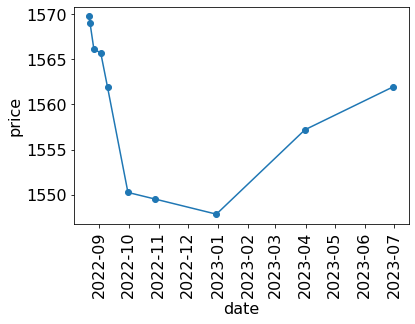

In [287]:
x, y = df_vol.index, df_vol['Forward']
fig = plt.figure()
plt.plot(x, y, 'o-')
plt.xticks(rotation = 90)
plt.xlabel('date'), plt.ylabel('price')
plt.show()

## Options

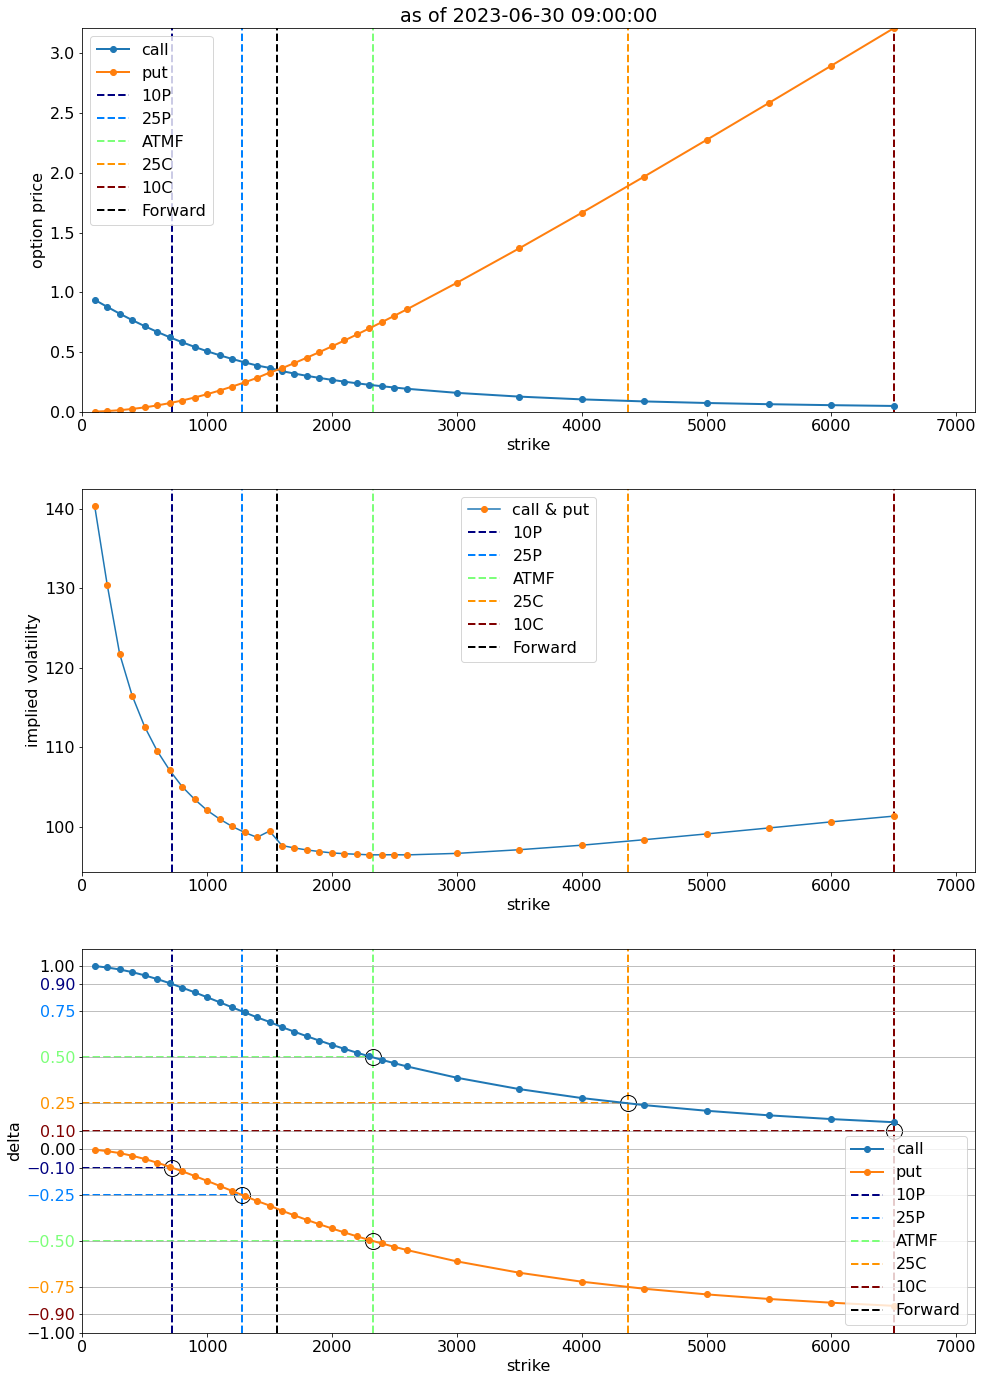

In [271]:
expiration_idx = -1
expiration_timestamp = ods.expiration_timestamps[expiration_idx]
fig = plt.figure(figsize=(16,24))
plt_tl = PlotTool(ods, expiration_timestamp)
plt_tl.plot()
plt.show()
